<a href="https://colab.research.google.com/github/vd4mmind/googleColab/blob/master/scRNAseq_PBMC_VD_DBS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [0]:
!pip install scanpy

     |████████████████████████████████| 6.5MB 76kB/s 
     |████████████████████████████████| 102kB 10.5MB/s 
     |████████████████████████████████| 2.9MB 29.4MB/s 
     |████████████████████████████████| 51kB 7.6MB/s 
  Found existing installation: h5py 2.8.0
    Uninstalling h5py-2.8.0:
      Successfully uninstalled h5py-2.8.0


In [0]:
import numpy as np
import pandas as pd
import scanpy as sc

# Loading data

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)

scanpy==1.4.5.1 anndata==0.7.1 umap==0.3.10 numpy==1.17.5 scipy==1.4.1 pandas==0.25.3 scikit-learn==0.22.1 statsmodels==0.10.2


In [0]:
ls "/content/drive/My Drive/scRNAseq Data/PBMC/"

annotation.csv              pbmc3k_filtered_gene_bc_matrices.tar.gz
filtered_gene_bc_matrices/  pbmc3k_final.rds


In [0]:
data = sc.read_10x_mtx(
    '/content/drive/My Drive/scRNAseq Data/PBMC/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)       

... writing an h5ad cache file to speedup reading next time


In [0]:
data

AnnData object with n_obs × n_vars = 2700 × 32738 
    var: 'gene_ids'

# Basic Filtering

Filtering out genes that are detected in less than 3 cells


In [0]:
sc.pp.filter_cells(data, min_genes=200)
sc.pp.filter_genes(data, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


Compute the fraction of mitochondrial genes and additional measures

In [0]:
mito_genes = data.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
data.obs['percent_mito'] = np.sum(
    data[:, mito_genes].X, axis=1).A1 / np.sum(data.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
data.obs['n_counts'] = data.X.sum(axis=1).A1

A violin plot of the computed quality measures

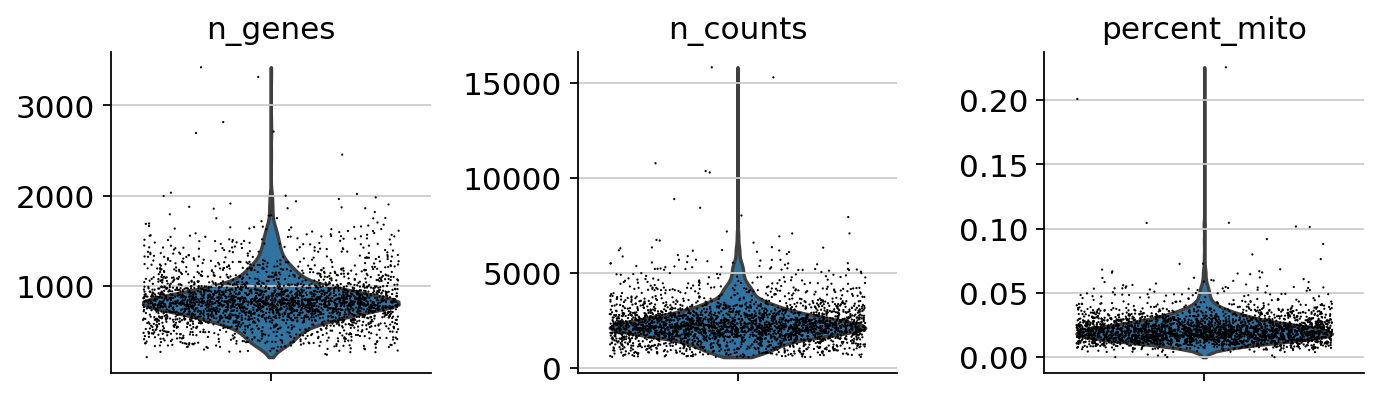

In [0]:
sc.pl.violin(data, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

Actual Filtering

In [0]:
data = data[data.obs.n_genes < 2500, :]
data = data[data.obs.percent_mito < 0.05, :]

Total-count normalize (library-size correct)

In [0]:
sc.pp.normalize_total(data, target_sum=1e4)

normalizing counts per cell
    finished (0:00:01)


Logarithmize the data

In [0]:
sc.pp.log1p(data)

/usr/local/lib/python3.6/dist-packages/scanpy/preprocessing/_simple.py:298: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


In [0]:
data.raw = data

Identify highly-variable genes

In [0]:
sc.pp.highly_variable_genes(data, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


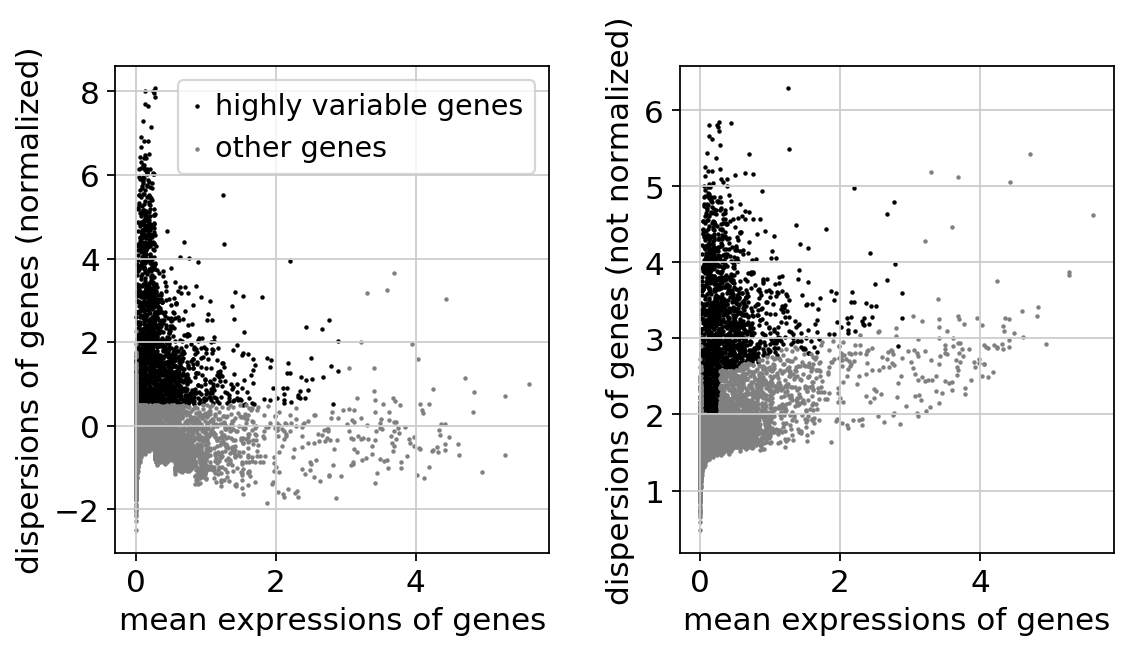

In [0]:
sc.pl.highly_variable_genes(data)

Select highly variable genes

In [0]:
data = data[:, data.var.highly_variable]

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [0]:
sc.pp.regress_out(data, ['n_counts', 'percent_mito'])

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:08)


Scale each gene to unit variance. Clip values exceeding standard deviation 10

In [0]:
sc.pp.scale(data, max_value=10)

# PCA

In [0]:
sc.tl.pca(data, svd_solver='arpack')

computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:00)


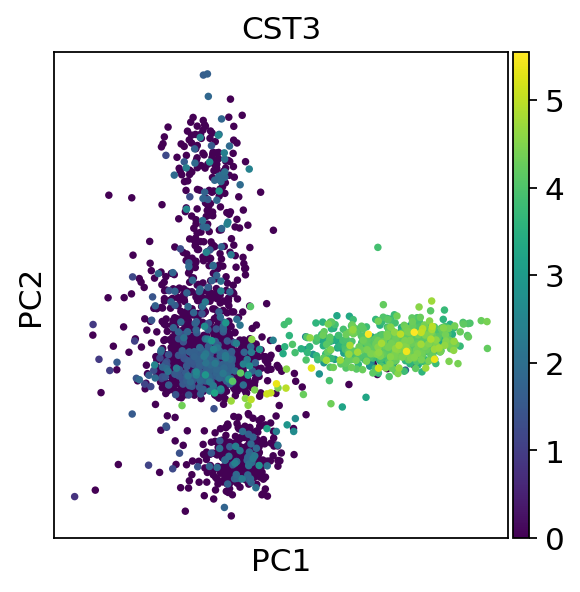

In [0]:
sc.pl.pca(data, color='CST3')

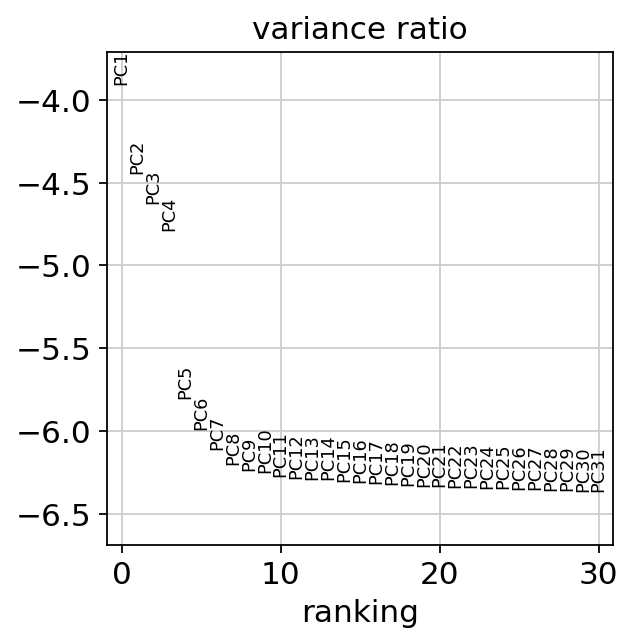

In [0]:
sc.pl.pca_variance_ratio(data, log=True)

# Computing the neighborhood graph

In [0]:
sc.pp.neighbors(data, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:02)


In [0]:
sc.tl.umap(data)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)


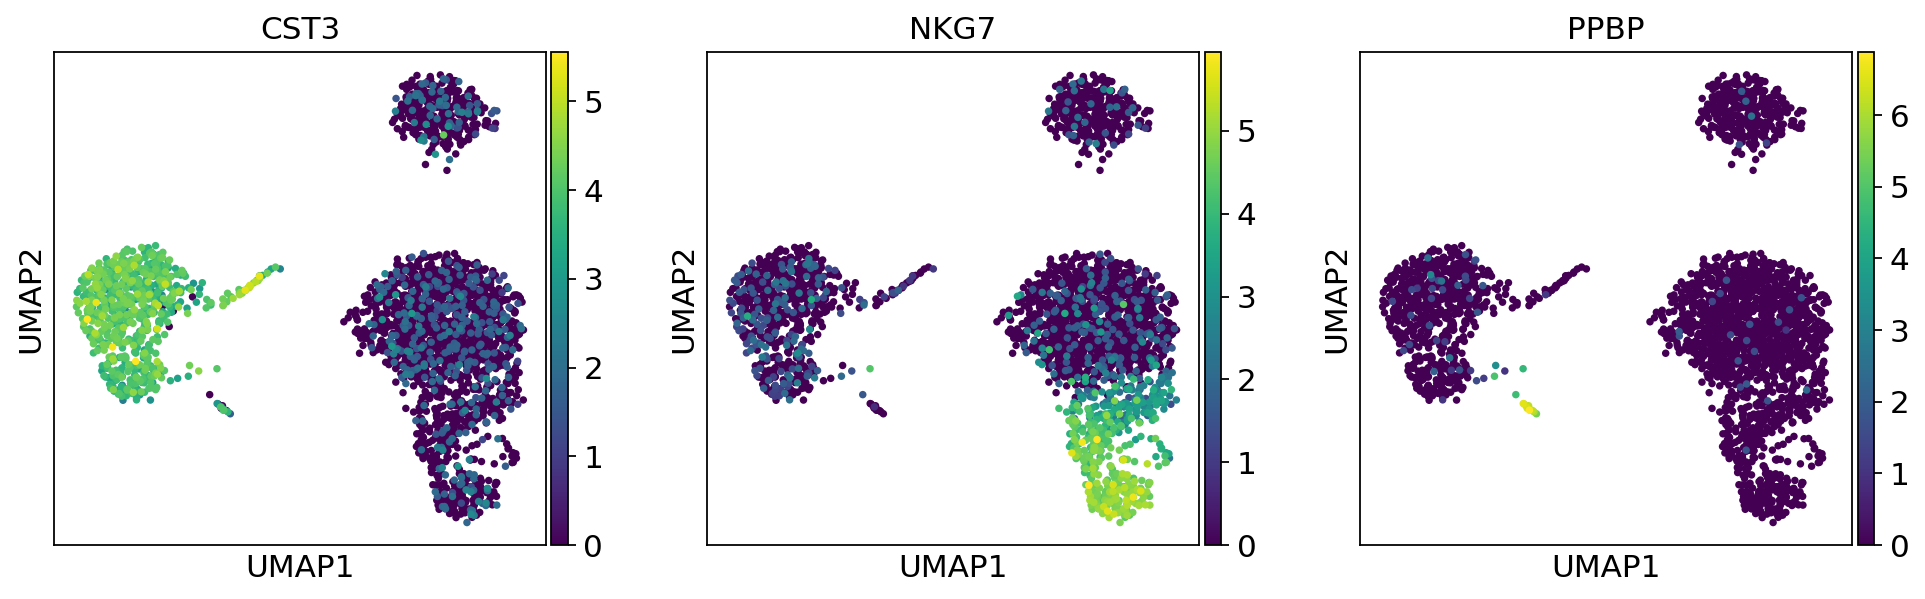

In [0]:
sc.pl.umap(data, color=['CST3', 'NKG7', 'PPBP'])

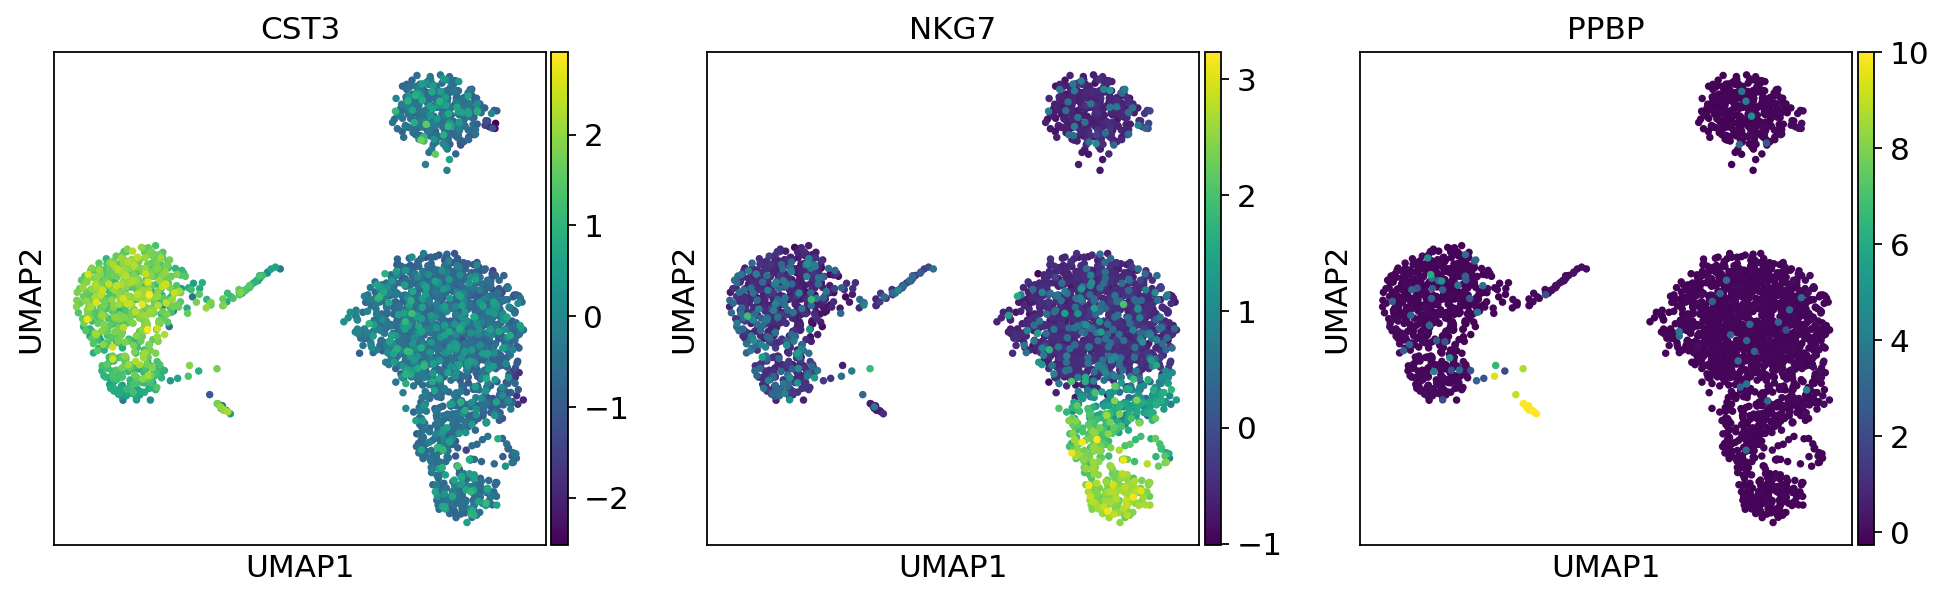

In [0]:
sc.pl.umap(data, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

# Clustering the neighborhood graph

In [0]:
!pip3 install leidenalg

     |████████████████████████████████| 102kB 2.3MB/s 
     |████████████████████████████████| 3.2MB 8.8MB/s 
  Created wheel for leidenalg: filename=leidenalg-0.7.0-cp36-cp36m-linux_x86_64.whl size=1107415 sha256=b0b32fda3668363ebe9c83ffa0c0bf6046a6b0b02d2042f7941b6bd57cd2a31e
  Stored in directory: /root/.cache/pip/wheels/29/55/48/5a04693a10f50297bcda23819ca23ab3470a61dd911851c8bd
Successfully built leidenalg


In [0]:
sc.tl.leiden(data)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


# Finding marker genes

Using t-test

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


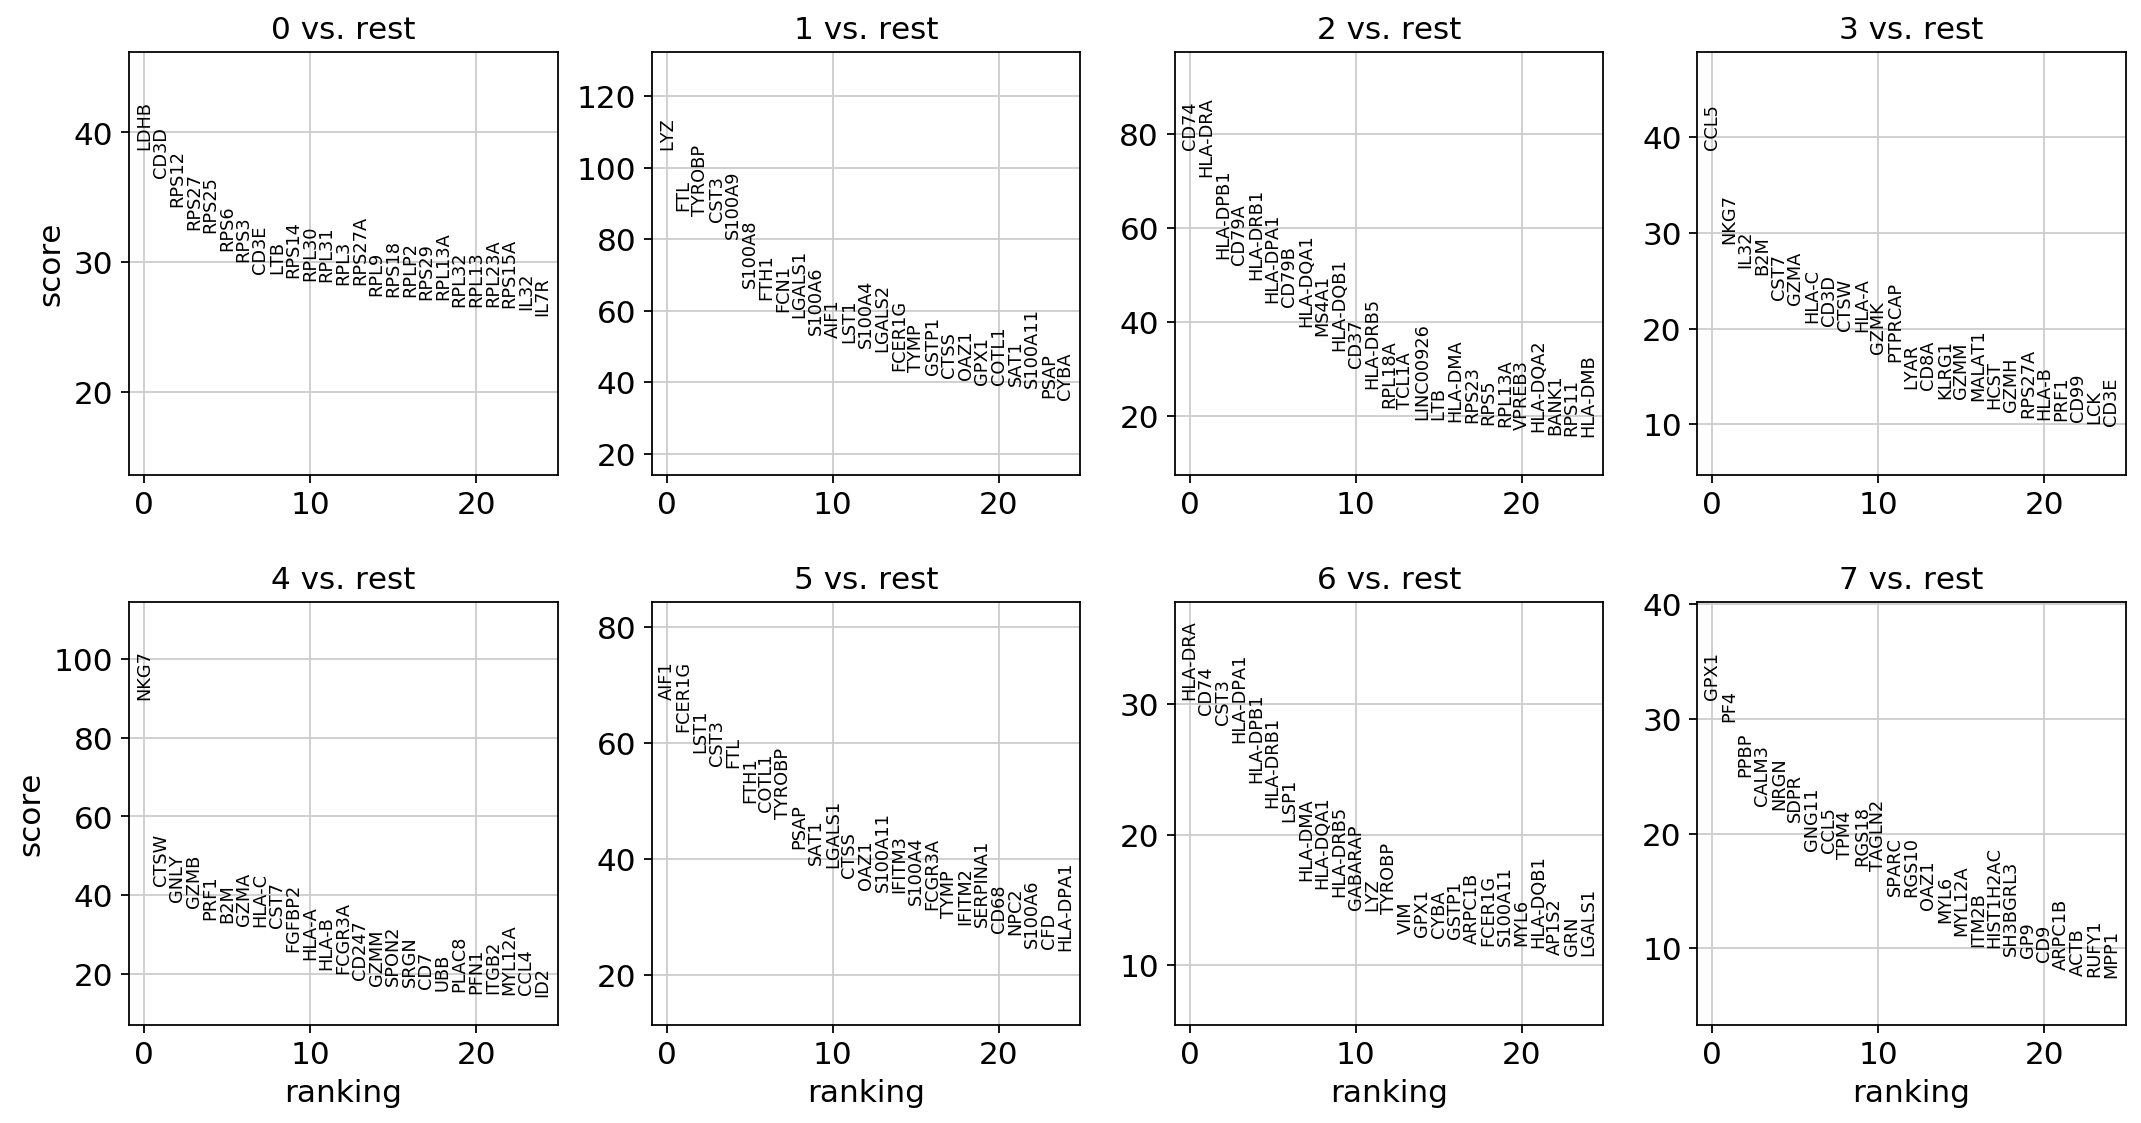

In [0]:
sc.tl.rank_genes_groups(data, 'leiden', method='t-test')
sc.pl.rank_genes_groups(data, n_genes=25, sharey=False)

In [0]:
sc.settings.verbosity = 2  # reduce the verbosity

Using Mann-Whitney test

ranking genes
    finished (0:00:02)


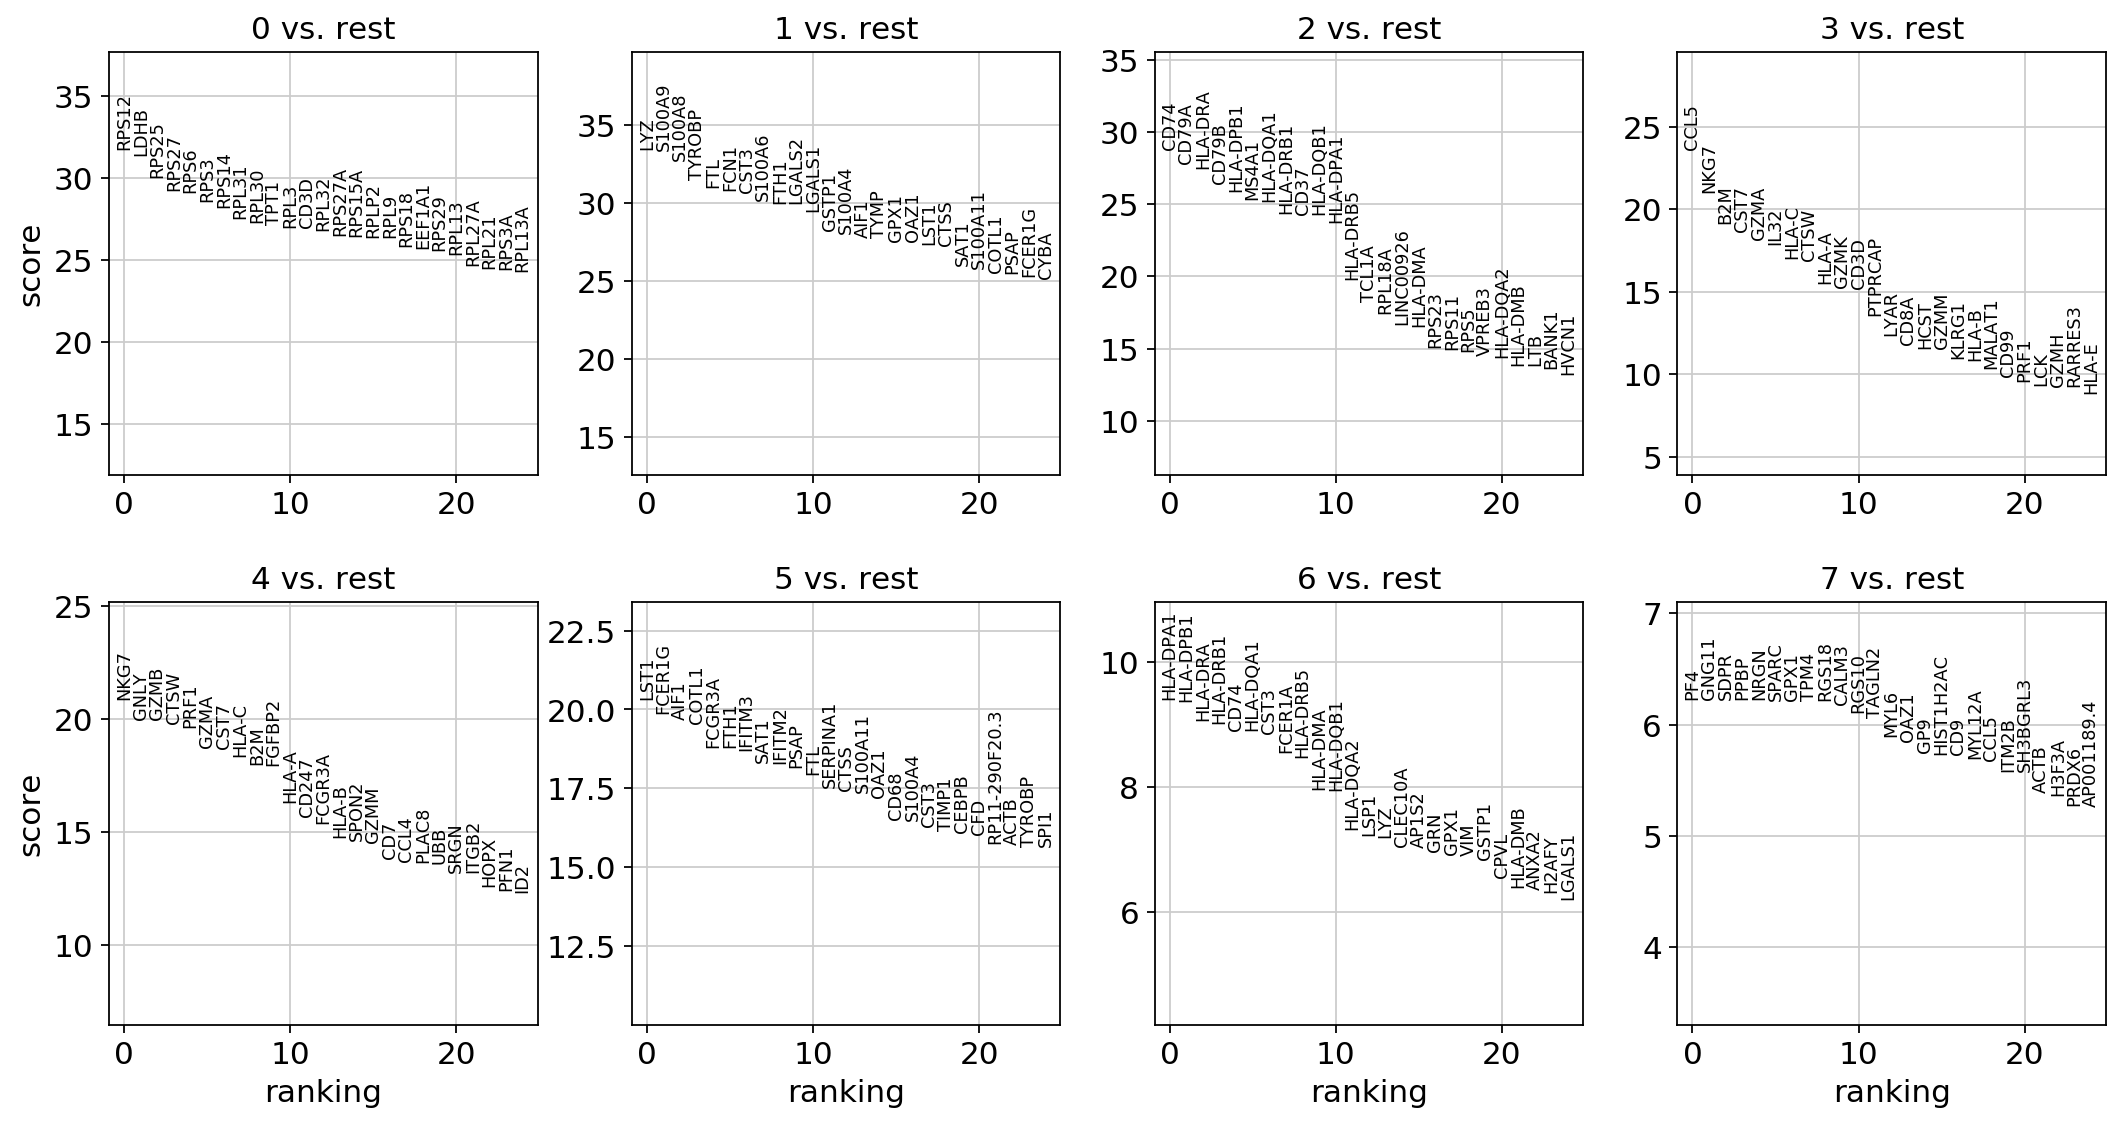

In [0]:
sc.tl.rank_genes_groups(data, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(data, n_genes=25, sharey=False)

Using logistic regression

ranking genes
    finished (0:00:11)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


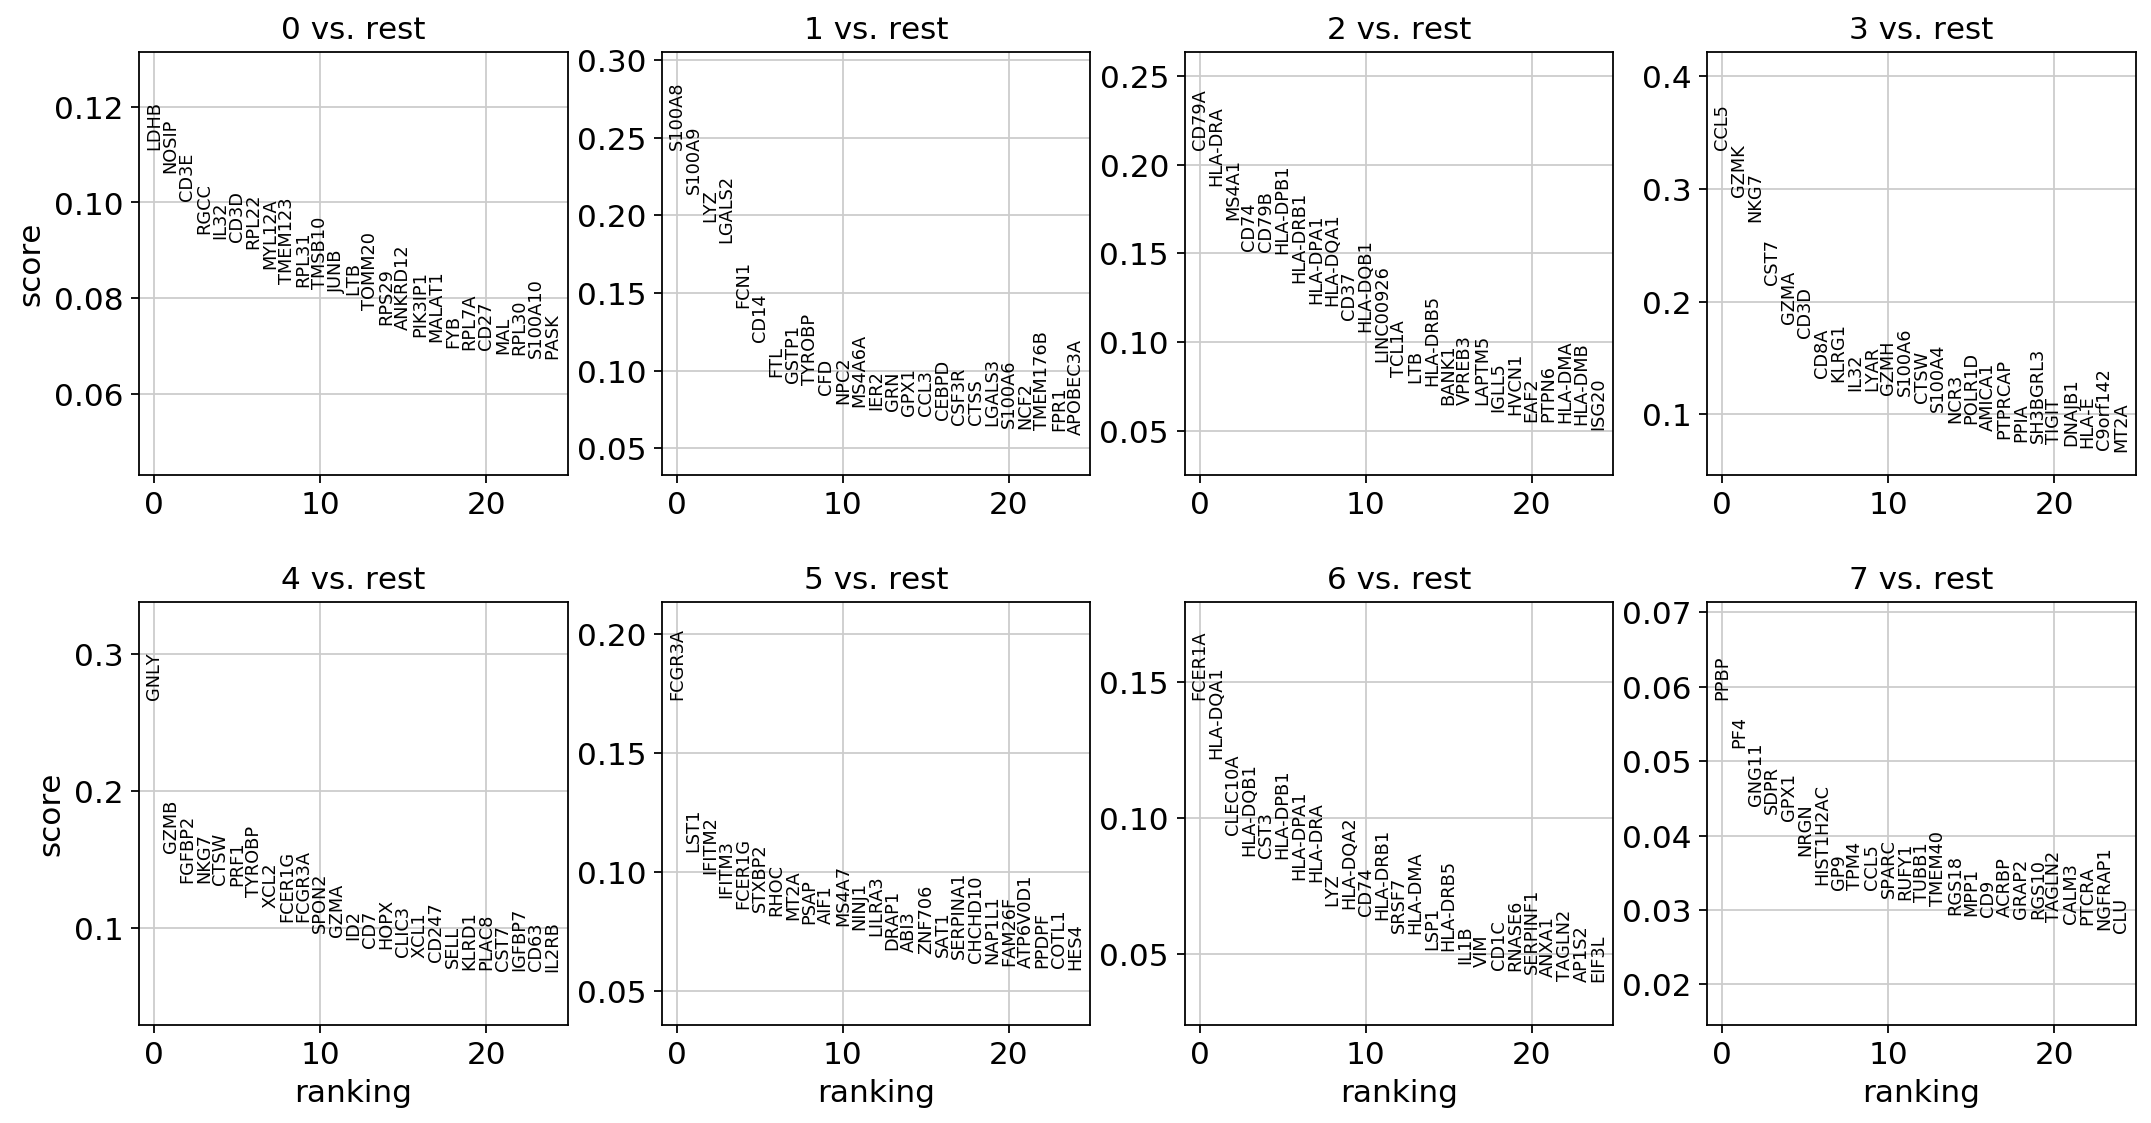

In [0]:
sc.tl.rank_genes_groups(data, 'leiden', method='logreg')
sc.pl.rank_genes_groups(data, n_genes=25, sharey=False)

In [0]:
data.obs

,n_genes,percent_mito,n_counts,leiden
AAACATACAACCAC-1,781,0.030178,2419.0,3
AAACATTGAGCTAC-1,1352,0.037936,4903.0,2
AAACATTGATCAGC-1,1131,0.008897,3147.0,0
AAACCGTGCTTCCG-1,960,0.017431,2639.0,5
AAACCGTGTATGCG-1,522,0.012245,980.0,4
...,...,...,...,...
TTTCGAACTCTCAT-1,1155,0.021104,3459.0,1
TTTCTACTGAGGCA-1,1227,0.009294,3443.0,2
TTTCTACTTCCTCG-1,622,0.021971,1684.0,2
TTTGCATGAGAGGC-1,454,0.020548,1022.0,2


In [0]:
np.unique(data.obs['leiden'])

array(['0', '1', '2', '3', '4', '5', '6', '7'], dtype=object)

# Cell Annontation

In [0]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

In [0]:
new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T',
    'NK', 'FCGR3A Monocytes',
    'Dendritic', 'Megakaryocytes']
data.rename_categories('leiden', new_cluster_names)

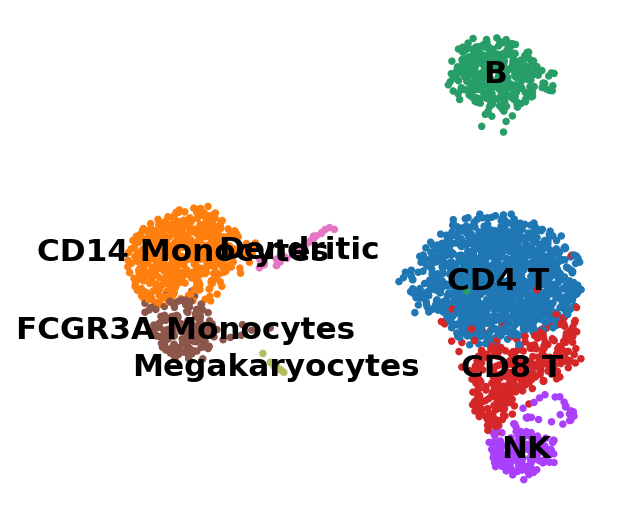

In [0]:
sc.pl.umap(data, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

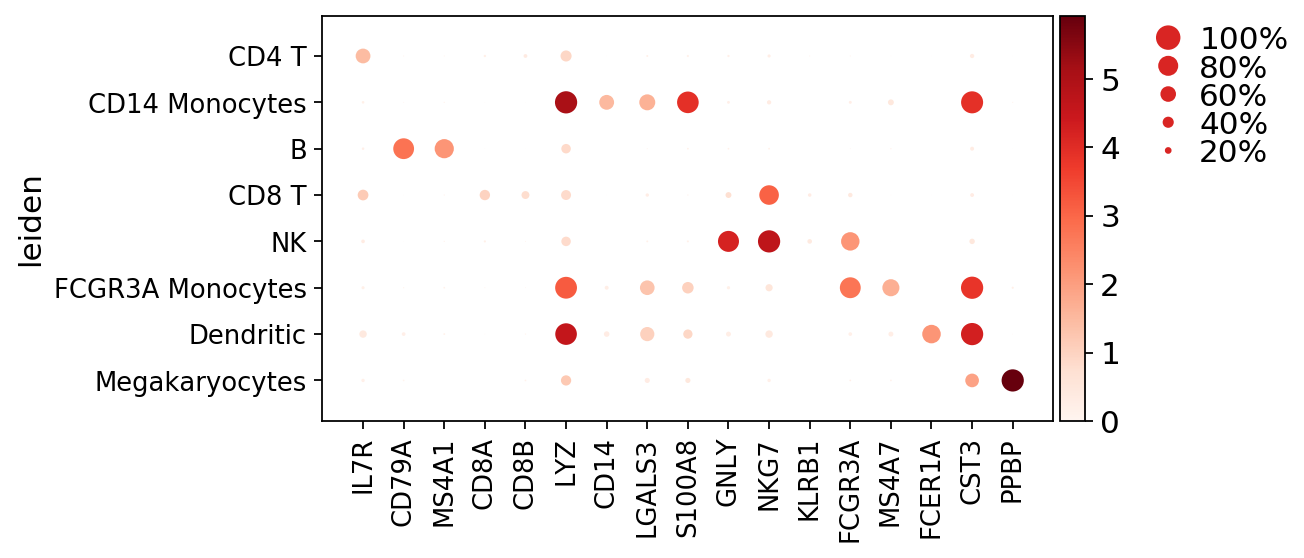

In [0]:
ax = sc.pl.dotplot(data, marker_genes, groupby='leiden')

In [0]:
data

AnnData object with n_obs × n_vars = 2638 × 1838 
    obs: 'n_genes', 'percent_mito', 'n_counts', 'leiden'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden', 'rank_genes_groups', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [0]:
data.obs

,n_genes,percent_mito,n_counts,leiden
AAACATACAACCAC-1,781,0.030178,2419.0,CD8 T
AAACATTGAGCTAC-1,1352,0.037936,4903.0,B
AAACATTGATCAGC-1,1131,0.008897,3147.0,CD4 T
AAACCGTGCTTCCG-1,960,0.017431,2639.0,FCGR3A Monocytes
AAACCGTGTATGCG-1,522,0.012245,980.0,NK
...,...,...,...,...
TTTCGAACTCTCAT-1,1155,0.021104,3459.0,CD14 Monocytes
TTTCTACTGAGGCA-1,1227,0.009294,3443.0,B
TTTCTACTTCCTCG-1,622,0.021971,1684.0,B
TTTGCATGAGAGGC-1,454,0.020548,1022.0,B


# Exporting data and labels

In [0]:
#data.obs[['n_genes', 'leiden']].to_csv('/content/drive/My Drive/scRNAseq Data/PBMC/annotation.csv')

In [0]:
pdata = pd.DataFrame(data.X)
#pdata.to_csv('/content/drive/My Drive/scRNAseq Data/PBMC/preprocessed_data.csv')

In [0]:
rdata = pd.DataFrame(data.raw.X)

In [0]:
rdata.head()

,0
0,"(0, 29)\t1.6358733\n (0, 73)\t1.6358733\n ..."
1,"(0, 14)\t1.625141\n (0, 26)\t1.1117153\n (..."
2,"(0, 11)\t1.429744\n (0, 16)\t1.429744\n (0..."
3,"(0, 11)\t3.55831\n (0, 26)\t1.5663872\n (0..."
4,"(0, 111)\t2.4162781\n (0, 186)\t3.0637722\n..."
